In [16]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipython-input-3590982206.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('RELIANCE.NS', period='2y', progress=False)


Gap Up Days: 264
Gap Down Days: 222


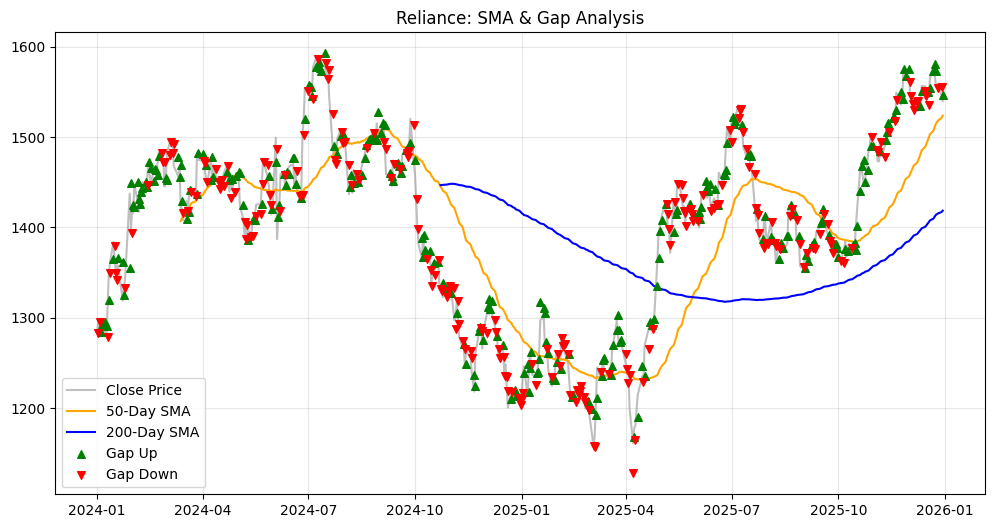


--- Fetching Intraday Data for VWAP ---


/tmp/ipython-input-3590982206.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  intra_df = yf.download('RELIANCE.NS', period='5d', interval='15m', progress=False)


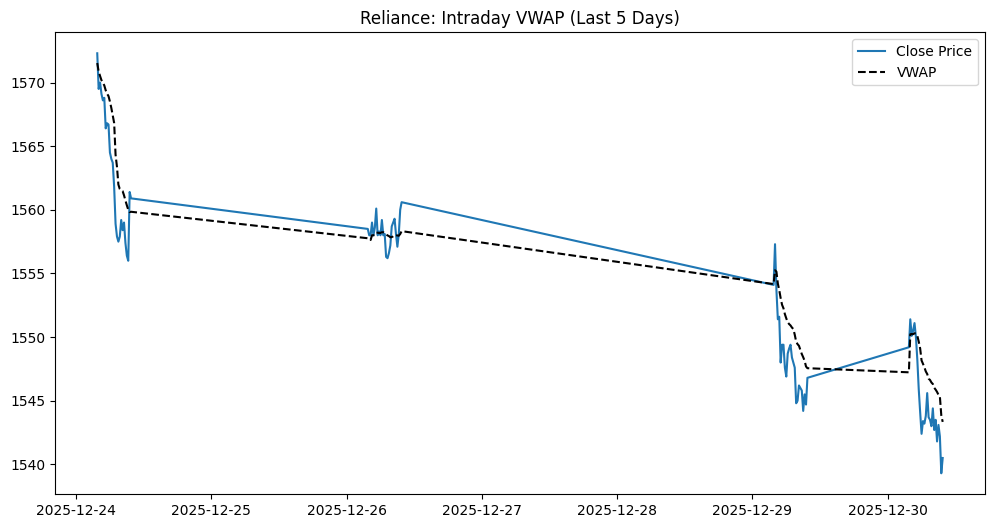

In [13]:
# PART 1: RELIANCE ANALYSIS

def analyze_reliance():
    df = yf.download('RELIANCE.NS', period='2y', progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    # Task 1: SMA
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()

    # Task 2: Gap Up and Gap Down
    df['Prev_Close'] = df['Close'].shift(1)
    gap_up = df[df['Open'] > df['Prev_Close']]
    gap_down = df[df['Open'] < df['Prev_Close']]

    print(f"Gap Up Days: {len(gap_up)}")
    print(f"Gap Down Days: {len(gap_down)}")

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5, color='gray')
    plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='orange')
    plt.plot(df.index, df['SMA_200'], label='200-Day SMA', color='blue')

    plt.scatter(gap_up.index, gap_up['Open'], color='green', marker='^', s=30, label='Gap Up', zorder=5)
    plt.scatter(gap_down.index, gap_down['Open'], color='red', marker='v', s=30, label='Gap Down', zorder=5)

    plt.title('Reliance: SMA & Gap Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Task 3: Intraday VWAP
    print("\n--- Fetching Intraday Data for VWAP ---")
    intra_df = yf.download('RELIANCE.NS', period='5d', interval='15m', progress=False)

    if isinstance(intra_df.columns, pd.MultiIndex):
        intra_df.columns = intra_df.columns.get_level_values(0)

    intra_df['Typical_Price'] = (intra_df['High'] + intra_df['Low'] + intra_df['Close']) / 3
    intra_df['TPV'] = intra_df['Typical_Price'] * intra_df['Volume']

    intra_df['Date_Only'] = intra_df.index.date
    intra_df['Cum_TPV'] = intra_df.groupby('Date_Only')['TPV'].cumsum()
    intra_df['Cum_Vol'] = intra_df.groupby('Date_Only')['Volume'].cumsum()
    intra_df['VWAP'] = intra_df['Cum_TPV'] / intra_df['Cum_Vol']

    plt.figure(figsize=(12, 6))
    plt.plot(intra_df.index, intra_df['Close'], label='Close Price')
    plt.plot(intra_df.index, intra_df['VWAP'], label='VWAP', linestyle='--', color='black')
    plt.title('Reliance: Intraday VWAP (Last 5 Days)')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    analyze_reliance()

In [19]:
# PART 2: TCS STRATEGY DEVELOPMENT

#1: Indicator Functions ---

def ind_bollinger(df, window=20):
    df = df.copy()
    sma = df['Close'].rolling(window=window).mean()
    std = df['Close'].rolling(window=window).std()
    df['BB_Upper'] = sma + (2 * std)
    df['BB_Lower'] = sma - (2 * std)
    return df

def ind_rsi(df, window=14):
    df = df.copy()
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def ind_macd(df):
    df = df.copy()
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

def ind_adx(df, window=14):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']

    df['+DM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > 0), df['UpMove'], 0)
    df['-DM'] = np.where((df['DownMove'] > df['UpMove']) & (df['DownMove'] > 0), df['DownMove'], 0)

    df['TR_s'] = df['TR'].rolling(window=window).mean()
    df['+DI'] = 100 * (df['+DM'].rolling(window=window).mean() / df['TR_s'])
    df['-DI'] = 100 * (df['-DM'].rolling(window=window).mean() / df['TR_s'])
    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window=window).mean()

    return df.drop(['H-L', 'H-PC', 'L-PC', 'TR', 'UpMove', 'DownMove', '+DM', '-DM', 'TR_s', 'DX'], axis=1)

def ind_stochastic(df, k_window=14, d_window=3):
    df = df.copy()
    low_min = df['Low'].rolling(window=k_window).min()
    high_max = df['High'].rolling(window=k_window).max()
    df['%K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    df['%D'] = df['%K'].rolling(window=d_window).mean()
    return df

def ind_atr(df, window=14):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    tr = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = tr.rolling(window=window).mean()
    return df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)

# 2: Signal Generation Functions

def sig_bollinger(df):
    signals = []
    for i in range(len(df)):
        if df['Close'].iloc[i] < df['BB_Lower'].iloc[i]: signals.append(1)
        elif df['Close'].iloc[i] > df['BB_Upper'].iloc[i]: signals.append(-1)
        else: signals.append(0)
    return pd.Series(signals, index=df.index)

def sig_rsi(df):
    signals = []
    for val in df['RSI']:
        if val < 30: signals.append(1)
        elif val > 70: signals.append(-1)
        else: signals.append(0)
    return pd.Series(signals, index=df.index)

def sig_macd(df):
    signals = np.where(df['MACD'] > df['Signal_Line'], 1, -1)
    return pd.Series(signals, index=df.index)

def sig_adx(df):
    signals = []
    for i in range(len(df)):
        if df['ADX'].iloc[i] > 25:
            if df['+DI'].iloc[i] > df['-DI'].iloc[i]: signals.append(1)
            elif df['-DI'].iloc[i] > df['+DI'].iloc[i]: signals.append(-1)
            else: signals.append(0)
        else: signals.append(0)
    return pd.Series(signals, index=df.index)

def sig_stochastic(df):
    signals = []
    for val in df['%K']:
        if val < 20: signals.append(1)
        elif val > 80: signals.append(-1)
        else: signals.append(0)
    return pd.Series(signals, index=df.index)

def sig_atr(df):
    signals = []
    for i in range(len(df)):
        if df['Close'].iloc[i] > (df['Open'].iloc[i] + df['ATR'].iloc[i]): signals.append(1)
        elif df['Close'].iloc[i] < (df['Open'].iloc[i] - df['ATR'].iloc[i]): signals.append(-1)
        else: signals.append(0)
    return pd.Series(signals, index=df.index)

# Part 2

def run_strategy():
    print("--- Fetching TCS Data (2023) ---")
    df = yf.download('TCS.NS', start='2023-01-01', end='2023-12-31', progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    strategies = {
        "Bollinger Bands": (ind_bollinger, sig_bollinger),
        "RSI": (ind_rsi, sig_rsi),
        "MACD": (ind_macd, sig_macd),
        "ADX": (ind_adx, sig_adx),
        "Stochastic": (ind_stochastic, sig_stochastic),
        "ATR": (ind_atr, sig_atr)
    }

    print("\n--- Strategy Signal Report ---")
    print(f"{'Indicator':<20} | {'Buy':<5} | {'Sell':<5}")
    print("-" * 35)

    for name, (ind_func, sig_func) in strategies.items():
        processed_df = ind_func(df)
        processed_df.dropna(inplace=True)
        signals = sig_func(processed_df)

        n_buy = len(signals[signals == 1])
        n_sell = len(signals[signals == -1])

        print(f"{name:<20} | {n_buy:<5} | {n_sell:<5}")

if __name__ == "__main__":
    run_strategy()

--- Fetching TCS Data (2023) ---

--- Strategy Signal Report ---
Indicator            | Buy   | Sell 
-----------------------------------
Bollinger Bands      | 6     | 14   
RSI                  | 22    | 40   
MACD                 | 138   | 107  
ADX                  | 106   | 65   
Stochastic           | 48    | 70   
ATR                  | 9     | 8    


/tmp/ipython-input-2762527489.py:120: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TCS.NS', start='2023-01-01', end='2023-12-31', progress=False)
